In [1]:
import sys
sys.path.append('..')

In [2]:
from random import choice, choices, sample
import collections 
import itertools
from mentors.constructions import conlon_ferber

In [3]:
cf8 = conlon_ferber(8)
print(cf8.clique_number(), cf8.complement().clique_number())

9 15


In [4]:
r39_graph6 = 'bsaCCA?O?O_aC??`c@O@b?RcHQ?DcA@H?PC_@QO@@Q?DA@MP?RgKADoH?aR?KCbOC_JE?xO@AALC@AJPG?__V?_K@ROO_A@dOG@?_'
r39 = Graph(r39_graph6)
print(r39.order(), r39.clique_number(), r39.complement().clique_number())

35 2 8


In [9]:
cf8.complement().subgraph_search(r39, induced=True)

KeyboardInterrupt: 

In [8]:
class LocalSearcher:

    def __init__(self, G):
        self.g = G
        self.g_comp = G.complement()

    def local_search(self, subg_size=17, s=4, t=4):
        '''Local search for a subgraph of the given size giving a lower bound for R(s, t)'''
        self.s_mult = s - 1
        self.t_mult = t - 1

        subg = self.g.subgraph(sample(self.g.vertices(), subg_size))
        
        print(f'Starting subgraph has order: {subg.order()}')
        print(f'Clique and Independence number: {subg.clique_number(), subg.complement().clique_number()}')

        for i in range(100000):
            subg = self.local_step(subg)
            
            cn = subg.clique_number()
            alpha = subg.complement().clique_number()
            print(f'Subg at iter {i} has CN and IN: {cn} {alpha}')
            if cn <= s-1 and alpha <= t-1:
                print(f'Found objective in iter {i}!')
                break

        return subg

    def local_step(self, subg):
        '''Eliminate and replace a vertex from a max clique or independent set (whichever is larger)'''
        
        # Pick a random max clique and independent set
        a_clique = choice(subg.cliques_maximum())
        a_indep = choice(subg.complement().cliques_maximum())
        
        # Weight the choice of vertex based on s and t
        if self.t_mult * len(a_clique) > self.s_mult * len(a_indep):
            to_remove = choice(a_clique)
            print('to_remove: clique')
        elif self.t_mult * len(a_clique) < self.s_mult * len(a_indep):
            to_remove = choice(a_indep)
            print('to_remove: indep')
        else:
            to_remove = choice(a_clique + a_indep)

        return self.find_replacement(subg, to_remove)

    def find_replacement(self, subg, to_remove):
        '''Find a vertex from self.g to replace to_remove in sub'''
        subg.delete_vertex(to_remove)
        sub_comp = subg.complement()

        # Iterate through the vertices of self.g, and score them based on the sizes / numbers of 
        # cliques and independent sets they create in sub
        best = (infinity, infinity)
        best_vs = None
        for v in self.g.vertices():
            if v not in subg and v != to_remove:
                score = self.score(subg, sub_comp, v)

                # Compare scores, and update best vertices found so far
                if score < best:
                    best = score
                    best_vs = [v]
                elif score == best:
                    best_vs.append(v)
        
        self.score(subg, sub_comp, best_vs[0], logging=True)
        return self.g.subgraph(subg.vertices() + [choice(best_vs)])

    def score(self, subg, sub_comp, v, logging=False):
        '''Compute a score for vertex v'''
        induced = subg.subgraph(self.g.neighbors(v))
        cliques = induced.cliques_maximum()

        comp_induced = sub_comp.subgraph(self.g_comp.neighbors(v))
        indeps = comp_induced.cliques_maximum()
        
        # Score = (size largest clique/IS, # of them), weighted by self.s and self.t
        # lower is better
        if self.t_mult * (len(cliques[0]) + 1) > self.s_mult * (len(indeps[0]) + 1):
            if logging:
                print('replace: clique')
                print(len(cliques[0]) + 1, len(indeps[0]) + 1)
            return ((len(cliques[0]) + 1) / self.s_mult, len(cliques) / self.s_mult)
        elif self.t_mult * (len(cliques[0]) + 1) < self.s_mult * (len(indeps[0]) + 1):
            if logging:
                print('replace: indep')
                print(len(cliques[0]) + 1, len(indeps[0]) + 1)
            return ((len(indeps[0]) + 1) / self.t_mult, len(indeps) / self.t_mult)
        else:
            return ((len(cliques[0]) + 1) / self.s_mult, (len(cliques) / self.s_mult) + (len(indeps) / self.t_mult))

In [9]:
subg = LocalSearcher(cf8).local_search(17, 4, 5)

Starting subgraph has order: 17
Clique and Independence number: (4, 4)
to_remove: clique
replace: indep
3 5
Subg at iter 0 has CN and IN: 4 5
to_remove: clique
replace: indep
3 5
Subg at iter 1 has CN and IN: 4 5
to_remove: clique
replace: indep
3 5
Subg at iter 2 has CN and IN: 4 5
to_remove: clique
replace: indep
3 5
Subg at iter 3 has CN and IN: 4 5
to_remove: clique
Subg at iter 4 has CN and IN: 4 5
to_remove: clique
replace: indep
3 5
Subg at iter 5 has CN and IN: 4 5
to_remove: clique
replace: indep
3 5
Subg at iter 6 has CN and IN: 3 5
to_remove: indep
Subg at iter 7 has CN and IN: 3 5
to_remove: indep
Subg at iter 8 has CN and IN: 3 4
Found objective in iter 8!


### Parallel computing

The below code uses the package `pebble` (install with `mamba install pebble`) to run a faster local search algorithm: just do the same thing 4 times in parallel! Since they are all randomized, we get to stop as soon as the fastest one finishes. 

In [10]:
from concurrent.futures import as_completed
from pebble import ProcessPool

searcher = LocalSearcher(cf8)
subg=None

# Super cool code that just runs serveral identical local searches in parallel, and stops after a single one finishes!
with ProcessPool(max_workers=4) as p:
    futures = [p.schedule(searcher.local_search, args=(17, 5, 4)) for _ in range(2)]

    for future in as_completed(futures):
        subg = future.result()
        print('first one completed')
        break
    print('terminating now!')
    for future in futures: future.cancel()

print('we escaped!')
print(subg)

Starting subgraph has order: 17
Clique and Independence number: (6, 4)
to_remove: clique
Subg at iter 0 has CN and IN: 5 4
to_remove: indep
Starting subgraph has order: 17
Clique and Independence number: (5, 5)
to_remove: indep
Subg at iter 1 has CN and IN: 5 4
to_remove: indep
Subg at iter 0 has CN and IN: 5 4
to_remove: indep
Subg at iter 2 has CN and IN: 5 4
to_remove: indep
Subg at iter 1 has CN and IN: 5 4
to_remove: indep
Subg at iter 3 has CN and IN: 5 3
to_remove: clique
Subg at iter 2 has CN and IN: 5 4
to_remove: indep
Subg at iter 4 has CN and IN: 4 3
Found objective in iter 4!
first one completed
terminating now!
we escaped!
Subgraph of ()


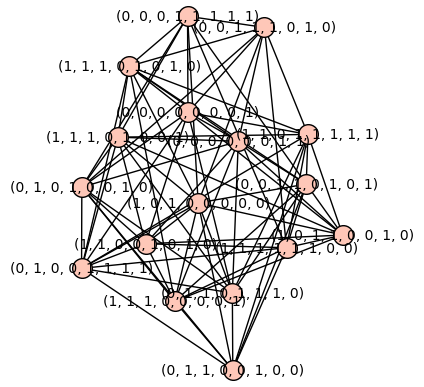

False
17 4 3


In [11]:
subg.show()
paley17=graphs.PaleyGraph(17)
print(subg.is_isomorphic(paley17))
print(subg.order(), subg.clique_number(), subg.complement().clique_number())

In [12]:
r35_graph6 = 'Ls`?XGRQR@B`Kc'
r35 = Graph(r35_graph6)
print(r35.order(), r35.clique_number(), r35.complement().clique_number())

13 2 4


In [34]:
subg = LocalSearcher(cf8).local_search(13, 3, 5)

Starting subgraph has order: 13
Clique and Independence number: (5, 5)
Subg at iter 0 has CN and IN: 4 5
Subg at iter 1 has CN and IN: 4 5
Subg at iter 2 has CN and IN: 3 5
Subg at iter 3 has CN and IN: 3 4
Subg at iter 4 has CN and IN: 3 4
Subg at iter 5 has CN and IN: 3 4
Subg at iter 6 has CN and IN: 3 4
Subg at iter 7 has CN and IN: 3 4
Subg at iter 8 has CN and IN: 3 4
Subg at iter 9 has CN and IN: 3 4
Subg at iter 10 has CN and IN: 3 4
Subg at iter 11 has CN and IN: 3 4
Subg at iter 12 has CN and IN: 3 4
Subg at iter 13 has CN and IN: 3 4
Subg at iter 14 has CN and IN: 3 4
Subg at iter 15 has CN and IN: 3 4
Subg at iter 16 has CN and IN: 3 4
Subg at iter 17 has CN and IN: 3 4
Subg at iter 18 has CN and IN: 3 4
Subg at iter 19 has CN and IN: 3 4
Subg at iter 20 has CN and IN: 3 4
Subg at iter 21 has CN and IN: 3 4
Subg at iter 22 has CN and IN: 3 4
Subg at iter 23 has CN and IN: 3 4
Subg at iter 24 has CN and IN: 3 4
Subg at iter 25 has CN and IN: 3 4
Subg at iter 26 has CN and IN

KeyboardInterrupt: 

In [35]:
cf12 = conlon_ferber(12)

In [38]:
print(cf12.order(), cf12.size(), cf12.complement().size())

4095 4193280 4189185


In [41]:
cf10 = conlon_ferber(10)

In [58]:
subg = LocalSearcher(cf10).local_search(13, 3, 5)

Starting subgraph has order: 13
Clique and Independence number: (4, 4)
to_remove: clique
Subg at iter 0 has CN and IN: 4 4
to_remove: clique
Subg at iter 1 has CN and IN: 4 4
to_remove: clique
Subg at iter 2 has CN and IN: 4 4
to_remove: clique
replace: indep
2 5
Subg at iter 3 has CN and IN: 3 5
to_remove: clique
replace: indep
2 5
Subg at iter 4 has CN and IN: 3 5
to_remove: clique
replace: indep
2 5
Subg at iter 5 has CN and IN: 3 5
to_remove: clique
replace: indep
2 5
Subg at iter 6 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 7 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 8 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 9 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 10 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 11 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 12 has CN and IN: 2 5
to_remove: indep
replace: indep
2 5
Subg at iter 13 has CN and IN:

KeyboardInterrupt: 